In [1]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore') #too many warnings (DataFrame.swapaxes is deprecated and will be removed in a future version)

col_names=['ch1','ch2','ch3','ch4']
gesture_names = ['Rest','Extension','Flexion','Ulnar Deviation','Radial Deviation','Grip','Abduction of Fingers','Adduction of Fingers','Supination','Pronation']

for i in range(40): #data1 to data40
    globals()['data{}'.format(i+1)] = pd.read_csv('/Users/jhr/workspace/GitHub/EMG_data_analysis/Dataset for multi-channel surface electromyography (sEMG) signals of hand gestures/sEMG-dataset/raw/csv/{}_raw.csv'.format(i+1), names=col_names)

    globals()['data{}_pattern'.format(i+1)] = [globals()['data{}'.format(i+1)][r:r + 268000] for r in range(0, len(globals()['data{}'.format(i+1)]), 268000)] #divide the data by 268000 steps at a time

    for f in col_names: #ch1 to ch4
        
        for j in range(5): #pattern1 to pattern5
            
            for g in range(10): #gesture1 to gesture10
                if g == 0: #make a dataframe what sets the standard index
                    globals()['data{}_gestures{}'.format(i+1,j+1)] = np.array_split(globals()['data{}_pattern'.format(i+1)][j].iloc[4000:204000], 10) #split the data into 10 gestures
                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)] = pd.DataFrame(globals()['data{}_gestures{}'.format(i+1,j+1)][g][f]) #new dataframe to set columns as gestures

                else: #appending the other features by pd.concat
                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)] = pd.concat([globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)],pd.DataFrame(globals()['data{}_gestures{}'.format(i+1,j+1)][g][f]).set_index(globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].index)],axis=1,join='inner')
                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].reset_index(drop=True, inplace=True) #reset the index

                    globals()['data{}_{}_gestures{}_only'.format(i+1,f,j+1)] = globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].iloc[4000:16000] #new dataframe without the rest time(0:4000, 16000:20000)
                    globals()['data{}_{}_gestures{}_only'.format(i+1,f,j+1)].reset_index(drop=True, inplace=True) #reset the index
            
            globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].columns = gesture_names #rename the columns by the exact gesture names
            globals()['data{}_{}_gestures{}_only'.format(i+1,f,j+1)].columns = gesture_names #rename the columns by the exact gesture names             



In [2]:
import matplotlib.pyplot as plt

In [3]:
data20_ch2_gestures2

,Rest,Extension,Flexion,Ulnar Deviation,Radial Deviation,Grip,Abduction of Fingers,Adduction of Fingers,Supination,Pronation
0,0.230408,0.137939,0.095215,0.115662,0.035400,-0.027771,-0.068359,0.114441,-0.046692,-0.769653
1,0.224609,0.139465,0.094604,0.109863,-0.012512,-0.015259,-0.062866,0.081177,-0.044556,-0.765076
2,0.221863,0.142822,0.097046,0.125427,-0.036926,-0.001831,-0.063477,0.057678,-0.038452,-0.758667
3,0.230408,0.142212,0.097961,0.137024,-0.027161,0.007019,-0.068359,-0.005798,-0.043030,-0.750427
4,0.237732,0.141907,0.095520,0.139465,-0.003357,0.014038,-0.059814,-0.010681,-0.042114,-0.746765
...,...,...,...,...,...,...,...,...,...,...
19995,0.163574,0.088196,0.154419,0.090942,-0.028687,-0.088196,0.031738,0.044250,-0.780029,-0.066528
19996,0.152283,0.099487,0.155640,0.064392,-0.028687,-0.063171,0.037842,0.046997,-0.785828,-0.082397
19997,0.147705,0.112915,0.133972,0.064392,-0.034790,-0.052795,0.064392,0.042419,-0.789185,-0.092468
19998,0.149231,0.112305,0.119019,0.090942,-0.043640,-0.058594,0.077820,0.014648,-0.787659,-0.103760


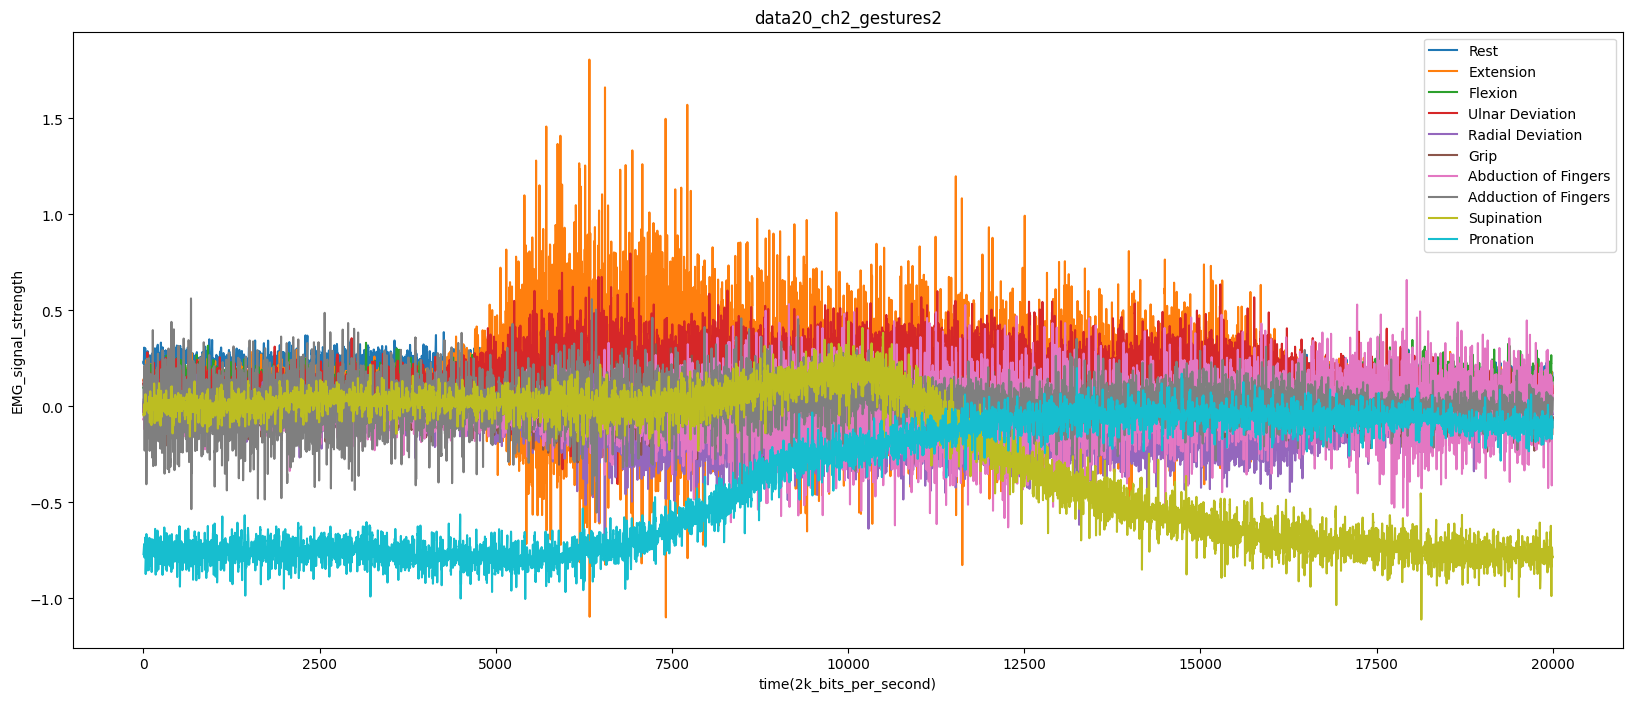

In [4]:
plt.figure(figsize=(20,8))
plt.plot(data20_ch2_gestures2, label=data20_ch2_gestures2.columns)  

plt.title('data20_ch2_gestures2')
plt.xlabel('time(2k_bits_per_second)')
plt.ylabel('EMG_signal_strength')

plt.legend()
plt.show()

In [5]:
data40_ch4_gestures5_only

,Rest,Extension,Flexion,Ulnar Deviation,Radial Deviation,Grip,Abduction of Fingers,Adduction of Fingers,Supination,Pronation
0,-0.003052,0.000000,-0.018311,0.000610,0.001831,-0.001526,-0.002441,-0.049744,-0.000610,-0.003357
1,-0.003052,0.000305,-0.017090,0.001526,0.002136,-0.001831,-0.001221,-0.043335,-0.001526,-0.005188
2,-0.002747,0.000000,-0.016479,0.002136,0.001831,-0.001831,0.000610,-0.037231,-0.002136,-0.004578
3,-0.002136,-0.000305,-0.015564,0.002136,0.001221,-0.001831,0.001526,-0.030212,-0.001526,-0.003052
4,-0.001221,-0.000916,-0.011902,0.002136,0.000610,-0.001526,0.001221,-0.024109,0.000610,-0.000916
...,...,...,...,...,...,...,...,...,...,...
11995,-0.000916,-0.010071,0.010681,-0.000916,-0.011597,0.003967,-0.015564,0.000305,0.000610,0.001831
11996,-0.000916,-0.006104,-0.009155,-0.000916,-0.006714,0.004578,-0.046997,0.001831,0.000000,0.002136
11997,-0.000610,-0.002747,-0.021667,-0.000916,0.002441,0.004578,-0.068359,0.003052,-0.000916,0.001831
11998,0.000305,-0.000610,-0.019531,-0.000610,0.008545,0.004883,-0.065002,0.004578,-0.001526,0.000916


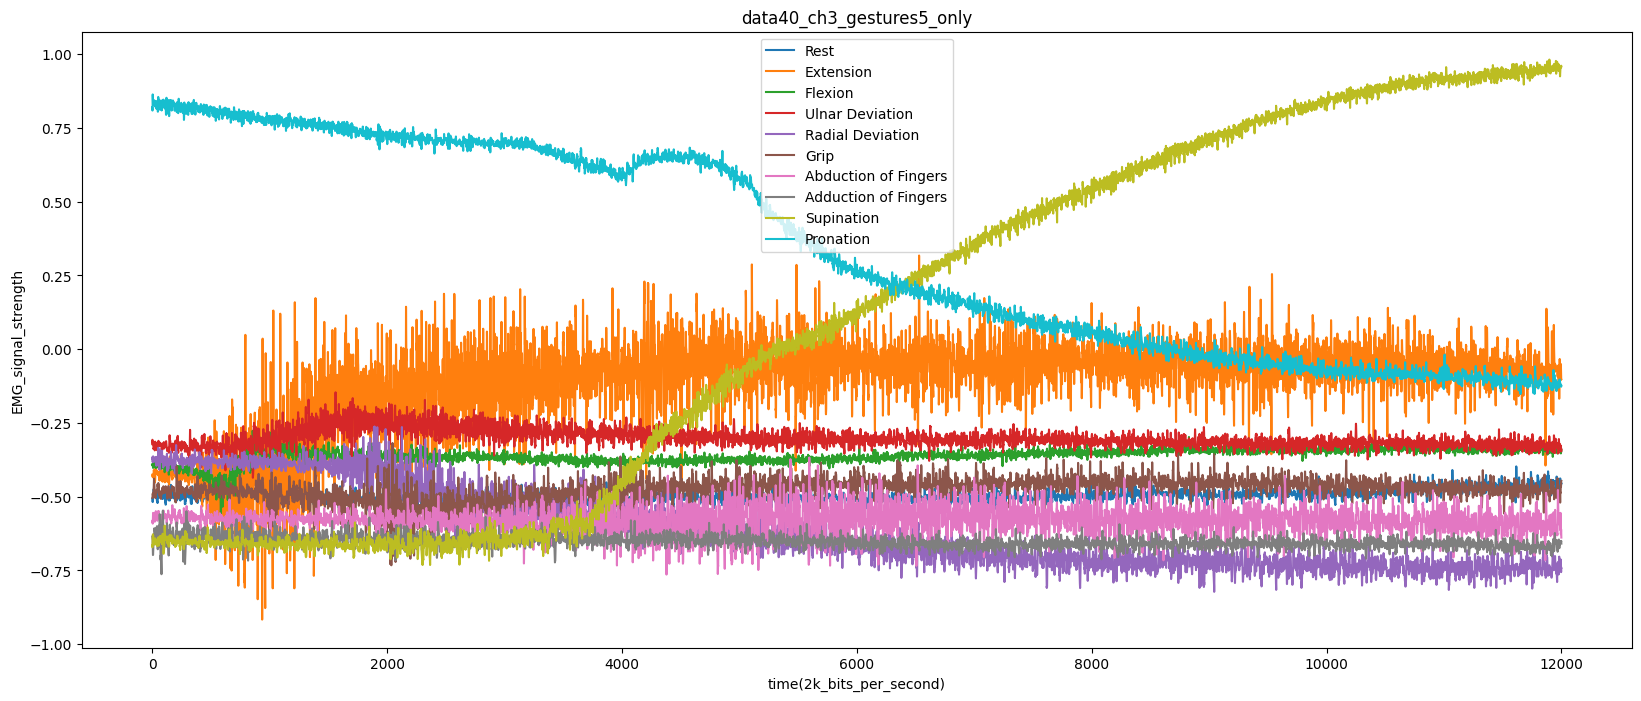

In [6]:
plt.figure(figsize=(20,8))
plt.plot(data40_ch3_gestures5_only, label=data40_ch3_gestures5_only.columns)  

plt.title('data40_ch3_gestures5_only')
plt.xlabel('time(2k_bits_per_second)')
plt.ylabel('EMG_signal_strength')

plt.legend()
plt.show()